Hand gesture recognition model using MobileNet V2

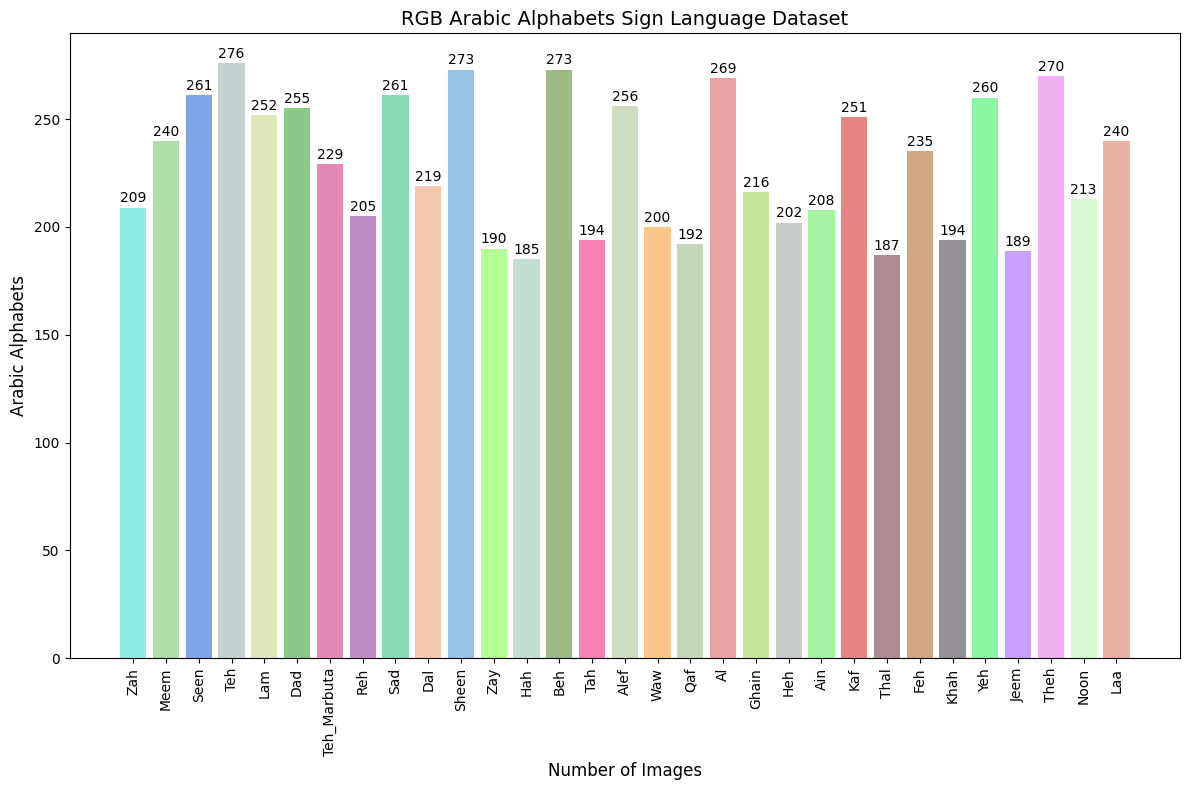

In [1]:
import os
import matplotlib.pyplot as plt
import random
from matplotlib.colors import rgb2hex

base_path = "/kaggle/input/full-extracted-hands/Full_Extracted_Hands"

folder_names = []
image_counts = []

for folder in os.listdir(base_path):
    folder_path = os.path.join(base_path, folder)
    if os.path.isdir(folder_path): 
        folder_names.append(folder) 
        image_counts.append(len([file for file in os.listdir(folder_path) if file.endswith(('.png', '.jpg', '.jpeg'))])) 

def generate_light_color():
    base_color = [random.uniform(0.5, 1) for _ in range(3)]  # توليد قيم ألوان RGB فاتحة
    return rgb2hex(base_color)

colors = [generate_light_color() for _ in folder_names]

plt.figure(figsize=(12, 8))
bars = plt.bar(folder_names, image_counts, color=colors)


for bar, count in zip(bars, image_counts):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 1, str(count), 
             ha='center', va='bottom', fontsize=10, color='black')

plt.xlabel("Number of Images", fontsize=12)  
plt.ylabel("Arabic Alphabets", fontsize=12)  
plt.title("RGB Arabic Alphabets Sign Language Dataset", fontsize=14)
plt.xticks(rotation=90, fontsize=10) 
plt.yticks(fontsize=10) 
plt.tight_layout()

plt.show()

In [ ]:
#  Import the required libraries:
import os
import warnings
import numpy as np
from PIL import Image, ImageEnhance, ImageFile
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import arabic_reshaper
from bidi.algorithm import get_display
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, BatchNormalization, Dropout
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
import tensorflow as tf
import time

warnings.filterwarnings('ignore', category=UserWarning, module='librosa')
ImageFile.LOAD_TRUNCATED_IMAGES = True
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'


In [2]:
# List of Arabic letters
arabic_letters_unicode = ['ع', 'ال', 'أ', 'ب', 'ض', 'د', 'ف', 'غ', 'ح', 'ه', 'ج', 'ك',  
                          'خ', 'لأ', 'ل', 'م', 'ن', 'ق', 'ر', 'ص', 'س', 'ش', 'ت', 
                          'ط', 'ة', 'ذ',  'ث', 'و', 'ي','ظ', 'ز']



# Step 1 ---- Read the Dataset
dataset3_path = "/kaggle/input/full-extracted-hands/Full_Extracted_Hands"
augmented_path = "/kaggle/working/Augmented_Dataset"
os.makedirs(augmented_path, exist_ok=True)

data = []
labels = []
categories = np.sort(os.listdir(dataset3_path))


# Setting up the dictionary to associate categories with Arabic letters
# Make sure the number in `categories` matches the number of letters in `arabic_letters_unicode`
category_to_arabic = {categories[i]: arabic_letters_unicode[i] for i in range(len(categories))}

print(category_to_arabic)



# Step 2 ---- Data Augmentation, Preprocessing, and Split Dataset
for category in categories:
    category_path = os.path.join(dataset3_path, category)
    augmented_category_path = os.path.join(augmented_path, category)
    os.makedirs(augmented_category_path, exist_ok=True)

    if os.path.isdir(category_path):
        images = os.listdir(category_path)
        image_count = 0

        for img_name in images:
            if image_count >= 400:
                break
            img_path = os.path.join(category_path, img_name)

            if img_name.lower().endswith(('.png', '.jpg', '.jpeg')):
                img = load_img(img_path, target_size=(224, 224))
                img_array = img_to_array(img) / 255.0
                data.append(img_array)
                labels.append(category)
                image_count += 1

                for i in range(3):
                    if image_count >= 400:
                        break
                    aug_img = img.copy()
                    aug_img = aug_img.rotate(np.random.uniform(-10, 10))
                    enhancer = ImageEnhance.Brightness(aug_img)
                    aug_img = enhancer.enhance(np.random.uniform(0.8, 1.2))

                    if np.random.rand() > 0.5:
                        aug_img = aug_img.transpose(Image.FLIP_LEFT_RIGHT)

                    aug_img_array = img_to_array(aug_img) / 255.0
                    data.append(aug_img_array)
                    labels.append(category)
                    image_count += 1  

        print(f"Processed {image_count} images for category: {category}")

print(f"Total images added: {len(data)}")
print(f"Total images added: {len(data)}")


# Convert lists to arrays
data = np.array(data)
labels = np.array(labels)

# Label encryption and data partitioning
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(labels)
categorical_labels = to_categorical(encoded_labels)

# Split Dataset (80% Training, 10% Validation, 10% Testing)
X_train, X_test, y_train, y_test = train_test_split(data, categorical_labels, test_size=0.2, random_state=42, shuffle=True)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5, random_state=42, shuffle=True)

print(f'X_train shape is {X_train.shape}')
print(f'X_val shape is {X_val.shape}')
print(f'X_test shape is {X_test.shape}')
print(f'y_train shape is {y_train.shape}')
print(f'y_val shape is {y_val.shape}')
print(f'y_test shape is {y_test.shape}')



# Step 3 ---- Modeling and Training

# Load the base model with ImageNet weights without the top classification layer
MobileNetV2_base = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3),pooling='avg')

# Freeze the basic model layers
MobileNetV2_base.trainable = False  

# Build the custom model by adding upper layers to the MobileNet V2 base model
trained_model = Sequential([
    MobileNetV2_base,
    Dense(1024, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(512, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(31, activation='softmax')
])

model.build(input_shape=(None, 224, 224, 3))  # Build the full model
model.summary()   # Review of the model summary


# Plot the model architecture
tf.keras.utils.plot_model(model, to_file='keras_model.png', show_shapes=True, 
                          show_layer_names=True, show_dtype=True, dpi=60)


# Settings for parameters used to stop the training process
trained_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                      loss='categorical_crossentropy', metrics=['accuracy'])

callbacks_list = [
# ModelCheckpoint callback to save the model weights at the end of each epoch if validation accuracy improved
ModelCheckpoint("weights.best.keras",
                 monitor='val_loss', # Metric to monitor for saving the best model 
                 save_best_only=True,# Save only the best model (based on the monitored metric) 
                 verbose=1           # Verbosity mode; 1 will print messages when saving the model
                 mode='min', 
                ),
    
# EarlyStopping callback to stop training when the validation accuracy does not improve
EarlyStopping( monitor='val_loss',  # Metric to monitor for early stopping
               verbose=1,           # Verbosity mode; 1 will print messages when stopping
               patience=10          # Number of epochs with no improvement after which training will be stopped
               mode='min', 
              ),
ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6)  
                 ]
# Model Training
start_time = time.time()
history = trained_model.fit(X_train, y_train, batch_size=32, epochs=100, validation_data=(X_val, y_val), callbacks=callbacks_list)
training_time = time.time() - start_time
print(f"Training time: {time.time() - start_time} seconds")


Processed 400 images for category: Zah
Processed 400 images for category: Meem
Processed 400 images for category: Seen
Processed 400 images for category: Teh
Processed 400 images for category: Lam
Processed 400 images for category: Dad
Processed 400 images for category: Teh_Marbuta
Processed 400 images for category: Reh
Processed 400 images for category: Sad
Processed 400 images for category: Dal
Processed 400 images for category: Sheen
Processed 400 images for category: Zay
Processed 400 images for category: Hah
Processed 400 images for category: Beh
Processed 400 images for category: Tah
Processed 400 images for category: Alef
Processed 400 images for category: Waw
Processed 400 images for category: Qaf
Processed 400 images for category: Al
Processed 400 images for category: Ghain
Processed 400 images for category: Heh
Processed 400 images for category: Ain
Processed 400 images for category: Kaf
Processed 400 images for category: Thal
Processed 400 images for category: Feh
Processed 

I0000 00:00:1731478522.540323     120 service.cc:145] XLA service 0x583cd12e6670 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1731478522.540389     120 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0


  8/620 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - accuracy: 0.0679 - loss: 4.7040 

I0000 00:00:1731478530.311965     120 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


618/620 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.1672 - loss: 3.6111
Epoch 1: val_loss improved from inf to 0.94564, saving model to weights.best.keras
620/620 ━━━━━━━━━━━━━━━━━━━━ 31s 28ms/step - accuracy: 0.1678 - loss: 3.6072 - val_accuracy: 0.7081 - val_loss: 0.9456 - learning_rate: 1.0000e-04
Epoch 2/100
618/620 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.5208 - loss: 1.5818
Epoch 2: val_loss improved from 0.94564 to 0.58604, saving model to weights.best.keras
620/620 ━━━━━━━━━━━━━━━━━━━━ 11s 17ms/step - accuracy: 0.5210 - loss: 1.5811 - val_accuracy: 0.8234 - val_loss: 0.5860 - learning_rate: 1.0000e-04
Epoch 3/100
620/620 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.6505 - loss: 1.0882
Epoch 3: val_loss improved from 0.58604 to 0.43879, saving model to weights.best.keras
620/620 ━━━━━━━━━━━━━━━━━━━━ 11s 17ms/step - accuracy: 0.6505 - loss: 1.0881 - val_accuracy: 0.8742 - val_loss: 0.4388 - learning_rate: 1.0000e-04
Epoch 4/100
620/620 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/s

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 1280)           │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 1024)           │     1,311,744 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 1024)           │         4,096 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 31)             │        15,903 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,116,575 (15.70 MB)

 Trainable params: 1,855,519 (7.08 MB)

 Non-trainable params: 2,261,056 (8.63 MB)

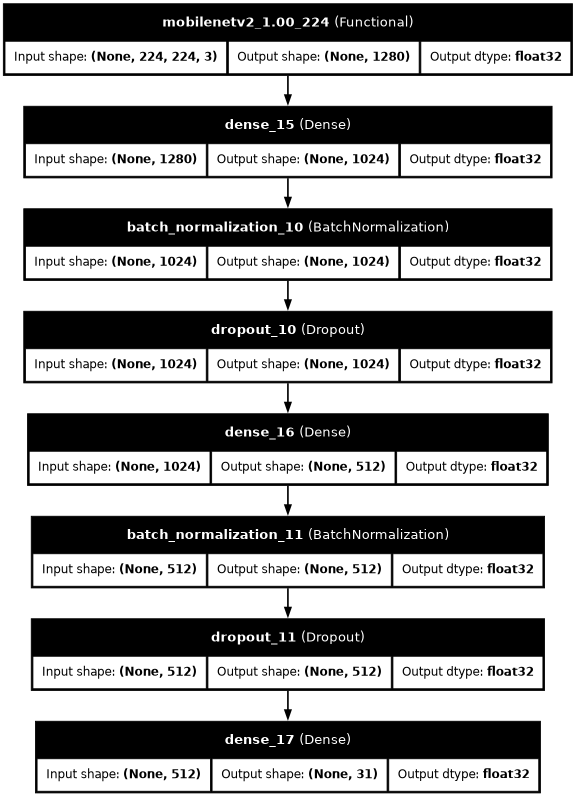

In [7]:
# This part explains the model's architecture
# Load the base model with ImageNet weights without the top classification layer
MobileNetV2_base = MobileNetV2(weights='imagenet', 
                               include_top=False,
                               input_shape=(224, 224, 3),
                               pooling='avg')

# Freeze the basic model layers
MobileNetV2_base.trainable = False  

# Build the custom model by adding upper layers to the MobileNet V2 base model
trained_model = Sequential([
    MobileNetV2_base,
    Dense(1024, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(512, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(31, activation='softmax')  # Number of classes 31 
])

model.build(input_shape=(None, 224, 224, 3))  # Build the full model
model.summary()   # Review of the model summary


# Plot the model architecture
tf.keras.utils.plot_model(model, to_file='keras_model.png', show_shapes=True, 
                          show_layer_names=True, show_dtype=True, dpi=60)

In [7]:
import time

Training_time= 591.052951335907
hours, remainder = divmod(Training_time, 3600)
minutes, seconds = divmod(remainder, 60)


# Print time in minutes, hours and seconds
print(f"Training Time: {int(hours)}h:{int(minutes)}m:{int(seconds)}s")

# Print accuracy and number of epoch
print(f"Best Evaluation Accuracy (val_accuracy): {max(history.history['val_accuracy']) * 100:.2f}%")
print(f"Best Training Accuracy (accuracy): {max(history.history['accuracy']) * 100:.2f}%")
print(f"Number of Epochs: {len(history.history['accuracy'])}")

# Get the value of learning_rate at the highest accuracy achieved
best_val_acc_epoch = np.argmax(history.history['val_accuracy'])


# Evaluate the model on test data
test_loss, test_accuracy = trained_model.evaluate(X_test, y_test)
print(f'Test Accuracy: {test_accuracy * 100:.2f}%')

Training Time: 0h:9m:51s
Best Evaluation Accuracy (val_accuracy): 0.9935
Best Training Accuracy (accuracy): 0.9920
Number of Epochs: 52
39/39 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - accuracy: 0.9842 - loss: 0.0503
Test Accuracy: 98.95%


In [8]:
# Save the form in H5 format
trained_model.save("trained_model_v2.h5")

# Convert model to TensorFlow Lite
converter = tf.lite.TFLiteConverter.from_keras_model(trained_model)
tflite_model = converter.convert()

# Save model in TensorFlow Lite format
tflite_model_path = "trained_model_v2.tflite"
with open(tflite_model_path, 'wb') as f:
    f.write(tflite_model)

print(f"TensorFlow Lite model saved at {tflite_model_path}")

39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step


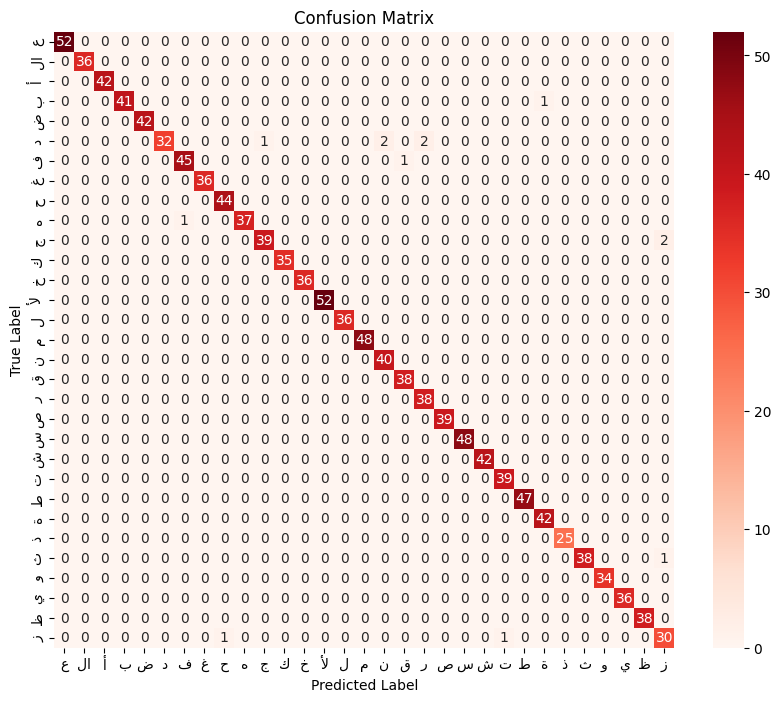

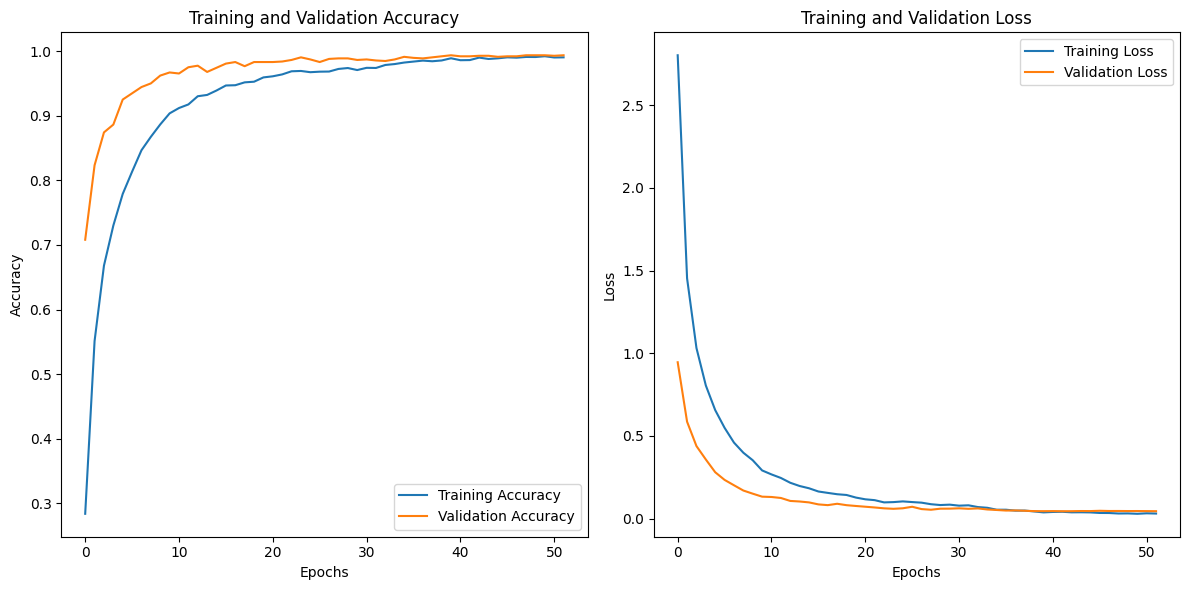

In [36]:
# ٍStep 4 ---- Accuracy
!pip install arabic-reshaper
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
import arabic_reshaper
from bidi.algorithm import get_display

arabic_letters_unicode = ['ع', 'ال', 'أ', 'ب', 'ض', 'د', 'ف', 'غ', 'ح', 'ه', 'ج', 'ك',  
                          'خ', 'لأ', 'ل', 'م', 'ن', 'ق', 'ر', 'ص', 'س', 'ش', 'ت', 
                          'ط', 'ة', 'ذ',  'ث', 'و', 'ي','ظ', 'ز']
class_mapping = dict(zip(range(len(arabic_letters_unicode)), arabic_letters_unicode))

reshaped_labels = [get_display(arabic_reshaper.reshape(label)) for label in arabic_letters_unicode]

# Predictions
y_pred = trained_model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Reds', 
            xticklabels=reshaped_labels,
            yticklabels=reshaped_labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


# Plotting training accuracy and validation accuracy
plt.figure(figsize=(12, 6))

# Plotting training accuracy
plt.subplot(1, 2, 1)  # Splitting the figure into 1 row and 2 columns, plotting in the first element
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plotting training loss and validation loss
plt.subplot(1, 2, 2)  # Plotting in the second element
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [27]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, classification_report

# Predictions Calculation
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

# Calculating accuracy, precision, recall, and F1 score
accuracy = accuracy_score(y_true_classes, y_pred_classes)
precision = precision_score(y_true_classes, y_pred_classes, average='weighted')
recall = recall_score(y_true_classes, y_pred_classes, average='weighted')
f1 = f1_score(y_true_classes, y_pred_classes, average='weighted')

# Print Performance Evaluation
print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')
print('\nClassification Report:')
print(classification_report(y_true_classes, y_pred_classes, target_names=categories))

Accuracy: 0.9895
Precision: 0.9898
Recall: 0.9895
F1 Score: 0.9894

Classification Report:
              precision    recall  f1-score   support

         Zah       1.00      1.00      1.00        52
        Meem       1.00      1.00      1.00        36
        Seen       1.00      1.00      1.00        42
         Teh       1.00      0.98      0.99        42
         Lam       1.00      1.00      1.00        42
         Dad       1.00      0.86      0.93        37
 Teh_Marbuta       0.98      0.98      0.98        46
         Reh       1.00      1.00      1.00        36
         Sad       0.98      1.00      0.99        44
         Dal       1.00      0.97      0.99        38
       Sheen       0.97      0.95      0.96        41
         Zay       1.00      1.00      1.00        35
         Hah       1.00      1.00      1.00        36
         Beh       1.00      1.00      1.00        52
         Tah       1.00      1.00      1.00        36
        Alef       1.00      1.00      1.00 